In [1]:
%reload_kedro

2023-09-11 14:36:56,356 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-09-11 14:36:56,733 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-09-11 14:36:56,826 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-09-11 14:36:56,827 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2023-09-11 14:36:56,833 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`


In [2]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
from xgboost import XGBClassifier
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
INDEX_COL = "window_nbr"
LABEL_COL = "label"

N_SPLITS = 5

In [4]:
mt_train = catalog.load("master_table_train_multic")
mt_train = mt_train.sort_values(by=INDEX_COL).reset_index(drop=True)

X_train, y_train = mt_train.drop(columns=[LABEL_COL]), mt_train[[INDEX_COL, LABEL_COL]]

2023-09-11 14:36:57,252 - kedro.io.data_catalog - INFO - Loading data from `master_table_train_multic` (ParquetDataSet)...


In [5]:
xgboost_default_params = catalog.load("params:xgboost_default_params")
model = XGBClassifier(**xgboost_default_params)

2023-09-11 14:36:57,306 - kedro.io.data_catalog - INFO - Loading data from `params:xgboost_default_params` (MemoryDataSet)...


/Users/gpalazzo/anaconda3/envs/msc/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [6]:
tss = TimeSeriesSplit(n_splits=N_SPLITS)
custom_cv = []
train_idxs = []
test_idxs = []

for train_index, test_index in tss.split(X_train):
    custom_cv.append((np.array(train_index), np.array(test_index)))
    train_idxs.append(train_index)
    test_idxs.append(test_index)

In [7]:
def build_xgboost_param_combinations():
    return {
    'eval_metric': ['auc'],
     'n_estimators': [300, 500, 1000],
     'max_depth': [3, 5],
     'reg_lambda': [0.05, 0.01, 0.1],
     'gamma': [0.01],
     'min_child_weight': [2.0],
     'learning_rate': [0.01, 0.05, 0.1],
     'objective': ['binary:logistic'],
     'sampling_method': ['uniform'],
     'tree_method': ['auto']
    }

In [8]:
grid = build_xgboost_param_combinations()
X_train = X_train.drop(columns=[INDEX_COL])
y_train = y_train.drop(columns=[INDEX_COL])

grid_search = GridSearchCV(estimator=model,
                            param_grid=grid,
                            n_jobs=-1,
                            cv=custom_cv,
                            scoring="accuracy",
                            error_score=0)

In [9]:
# grid_result = grid_search.fit(X_train, y_train)

# pprint(grid_result.best_params_)

## Plot Time Series Split (Folds)

In [15]:
def plot_split(train_idx_list, test_idx_list, title):
    
    # Plot the folds
    fig, ax = plt.subplots()

    for i, (train_idx, test_idx) in enumerate(zip(train_idx_list, test_idx_list)):
        if i == 0:
            ax.scatter(train_idx, [i+1]*len(train_idx), color='blue', label='Train' , s=50)
            ax.scatter(test_idx, [i+1]*len(test_idx), color='red', label='Test', s=50)
        else:
            ax.scatter(train_idx, [i+1]*len(train_idx), color='blue', s=50)
            ax.scatter(test_idx, [i+1]*len(test_idx), color='red', s=50)

    ax.set_xlabel('Index')
    ax.set_ylabel('Fold')
    # ax.set_ylim(bottom=1, top=3)
    
    ax.set_title(title)
    ax.legend(loc='best')
    
    fig = ax.get_figure()
    plt.show()

    return fig    

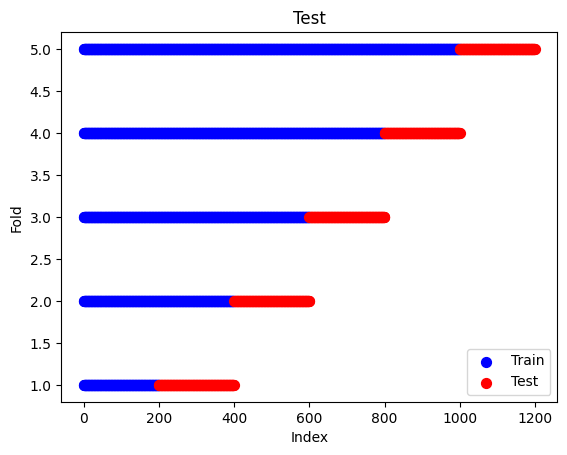

In [16]:
fig = plot_split(train_idx_list=train_idxs, test_idx_list=test_idxs, title="Test")

In [12]:
fig.savefig("/Users/gpalazzo/Desktop/fig_timeseries_folds_split.png")